# Area bias adjustment

The IFT separates nearby floes by morphological erosion. This method tends to result in floe boundaries that are well within the interior of the floe. We wish to adjust the area of segments so that we optimally match the true areas. Since our focus is on area distribution and the relationship between length scales and motion, we implement a simple bias adjustment for the total area. A comparison with a dilation method shows that the area bias change is equivalent.

Our procedure is as follows:
1. Select images for comparison
2. Overlay the segmentation results on the true color image. Manually identify the true boundaries of ice floes that significantly overlap with the segmentation results.
3. Identify cases where the intersection of the IFT floe and the true floe has area at least 90% of the IFT floe area.
4. Separate the data into training and test sets, then estimate the radius correction factor: $\delta r = \sqrt{A_{true}} - \sqrt{A_{IFT}}$
6. Finally, using the test set, compute the error for the best case scenarios (the good matches), the "clean" data, and all data.

In [1]:
import pandas as pd
import numpy as np
import os
import rasterio as rio
import skimage

In [2]:
# Binarize the labeled floes
data_loc = '../data/validation_images/'
save_loc = '../data/validation_images/'

files = [
    '20060710.terra.labeled_raw.250m.tiff',
    '20090403.terra.labeled_raw.250m.tiff',
    '20130424.aqua.labeled_raw.250m.tiff',
    '20140501.aqua.labeled_raw.250m.tiff',
    '20180607.aqua.labeled_raw.250m.tiff']
    
grayscale_threshold = 1/256

for file in files:
    new_fname = file.replace('labeled_raw', 'labeled_raw_binarized')

    im = rio.open(data_loc + file.split('.')[0] + '/' + file).read()

    # Convert to grayscale with equal weighting. Coastlines blur into the ocean
    # in the images, so we set a threshold to divide land and water.
    im = np.mean(im[:,:,:], axis=0)/255 # Convert to grayscale
    im = (im > grayscale_threshold).astype(int) * 255
    im = im.astype(np.uint8)
    
    skimage.io.imsave(save_loc + file.split('.')[0] + '/' + new_fname, im)

In [10]:
# Load ice floe properties for the relevant times
dfs = []
for year in [2006, 2009, 2013, 2014, 2018]:
    df = pd.read_csv('../data/floe_tracker/ift_floe_property_tables/raw/ift_raw_floe_properties_{y}.csv'.format(y=year), index_col=0)
    df['datetime'] = pd.to_datetime(df['datetime'].values)
    dfs.append(df)
df_props = pd.concat(dfs)

In [76]:
def select_relevant_set(label_i, gt_image, seg_image, gt_image_props, seg_image_props, thresh=0.5):
    """Identifies the set of labels in the segmented image corresponding
    to the "Relevant Set". label_i is the label in the ground truth image (gt_image),
    seg_image is a labeled image with a set of candidate objects to match. gt_image_props and
    seg_image_props are the results of skimage.measure.regionprops placed into a dictionary by 
    label. Each object sj in seg_image with a nonzero overlap with object gi in the gt_image is checked
    for 4 criteria: centroid(gi) in sj; centroid(sj) in gi, relative overlap(gi, sj) > thresh, or
    relative overlap(sj, gi) > thresh. Relative overlap (a, b) is |a intersect b|/|b|.
    Returns a list of possible indices."""

    # First grab any labels that have a nonzero intersection.
    # This is \tilde Y from Clinton et al. 2010
    possible = [x for x in np.unique(seg_image[gt_image == label_i]) if x != 0]
    
    if len(possible) == 0:
        return []

    reference_set = []
    for j in possible:
        
        # A: centroid(gi) in sj
        rg, cg = gt_image_props[label_i].centroid
        s_label = seg_image[int(np.round(rg)), int(np.round(cg))]
        in_A = s_label == j
        
        # B: centroid(sj) in gi
        rs, cs = seg_image_props[j].centroid
        g_label = gt_image[int(np.round(rs)), int(np.round(cs))]
        in_B = g_label == label_i
        
        # C: relative_overlap(g, s) > thresh
        overlap = np.sum((gt_image == label_i) & (seg_image == j))
        in_C = overlap/np.sum(seg_image == j) > thresh
        
        # D: relative_overlap(s, g) > thresh
        in_D = overlap/np.sum(gt_image == label_i) > thresh
        
        if np.any([in_A, in_B, in_C, in_D]):
            reference_set.append(j)

    return reference_set

In [66]:
"""Open labeled manual, raw, and cleaned imagery"""
ift_raw = {}
ift_clean = {}
man_images = {}
dataframes = {}
tc_images = {}

for date, satellite in zip(['2006-07-10 13:55:15', '2009-04-03 13:19:52', '2013-04-24 12:39:09', '2014-05-01 12:14:19', '2018-06-07 11:12:53'],
                           ['terra', 'terra', 'aqua', 'aqua', 'aqua']):
    date = pd.to_datetime(date)
    ymd = date.strftime('%Y%m%d')
    ift_raw[date] = skimage.io.imread(data_loc + ymd + '/{d}.{s}.labeled_raw.250m.tiff'.format(d=ymd, s=satellite))
    ift_clean[date] = skimage.io.imread(data_loc + ymd + '/{d}.{s}.labeled_clean.250m.tiff'.format(d=ymd, s=satellite))

    tc_images[date] = rio.open(data_loc + ymd + '/{d}.{s}.truecolor.250m.tiff'.format(d=ymd, s=satellite)).read()

    manual_fpath = data_loc + ymd + '/{d}.{s}.labeled_manual.png'.format(d=ymd, s=satellite)
    if os.path.exists(manual_fpath):
        # Set up dataframes with region properties
        im_manual = skimage.io.imread(manual_fpath)
        man_images[date] = skimage.measure.label(im_manual[:,:,0])
        df_manual = pd.DataFrame(skimage.measure.regionprops_table(man_images[date],
                                                               properties=['label',
                                                                           'area',
                                                                           'perimeter',
                                                                           'centroid',
                                                                           'axis_major_length',
                                                                           'axis_minor_length']))
        df_manual.rename({'centroid-0': 'row_pixel', 'centroid-1': 'col_pixel'}, axis=1, inplace=True)
        df_ift_raw = pd.DataFrame(skimage.measure.regionprops_table(ift_raw[date],
                                                               properties=['label',
                                                                           'area',
                                                                           'perimeter',
                                                                           'centroid',
                                                                           'axis_major_length',
                                                                           'axis_minor_length']))
        df_ift_raw.rename({'centroid-0': 'row_pixel', 'centroid-1': 'col_pixel'}, axis=1, inplace=True)
        
        df_manual = df_manual.add_prefix('manual_')
        df_ift_raw = df_ift_raw.add_prefix('ift_')

        # Link dataframes using the relevent sets
        manual_regions = skimage.measure.regionprops(man_images[date])
        ift_raw_regions = skimage.measure.regionprops(ift_raw[date])
        manual_regions = {x.label: x for x in manual_regions}
        ift_raw_regions = {x.label: x for x in ift_raw_regions}
        
        for region in manual_regions:
            rdata = manual_regions[region]
            label_i = rdata.label
            if rdata.area > 50:
                rel_set = select_relevant_set(label_i, man_images[date], ift_raw[date], manual_regions, ift_raw_regions, thresh=0.5)

                # If multiple matches, choose the one with the largest intersection
                if len(rel_set) > 1:
                    idx = 0
                    keep_idx = 0
                    intrsct = np.sum((man_images[date] == rdata.label) & (ift_raw[date] == rel_set[idx]))
                    for idx in range(1, len(rel_set)):
                        temp_intrsct = np.sum((man_images[date] == rdata.label) & (ift_raw[date] == rel_set[idx]))
                        if temp_intrsct > intrsct:
                            keep_idx = int(idx)
                    label_j = keep_idx
                elif len(rel_set) == 1:
                    label_j = rel_set[0]
                else:
                    label_j = None
            
                if label_j is not None:        
                    df_manual.loc[df_manual.manual_label == label_i, 'ift_label'] = label_j

                    # compute overlap fraction
                    man_floe = man_images[date] == rdata.label
                    ift_floe = ift_raw[date] == label_j
                    df_manual.loc[df_manual.manual_label == label_i, 'overlap_area'] = np.sum(man_floe & ift_floe)

                    
                df_manual.fillna(-1, inplace=True)
                df_manual['ift_label'] = df_manual['ift_label'].astype(int)
        dataframes[date] = df_ift_raw.merge(df_manual, left_on='ift_label',
                                            right_on='ift_label', how='outer')

    else:
        print(date)

In [81]:
df_all = pd.concat(dataframes, axis=0).reset_index() #.dropna(subset='manual_area')
df_all['ift_overlap_frac'] = df_all['overlap_area'] / df_all['ift_area']
df_all['man_overlap_frac'] = df_all['overlap_area'] / df_all['manual_area']
df_all.drop('level_1', axis=1, inplace=True)
df_all.rename({'level_0': 'datetime'}, axis=1, inplace=True)

In [82]:
df_props.rename({'label': 'ift_label'}, axis=1, inplace=True)

In [83]:
df_all = df_props.merge(df_all, left_on=['datetime', 'ift_label'], right_on=['datetime', 'ift_label'],
               how='outer').dropna(subset='ift_area')
df_all.loc[df_all.final_classification.isnull(), 'final_classification'] = False

In [80]:
import proplot as pplt

Index(['datetime', 'satellite', 'floe_id', 'ift_label', 'longitude',
       'latitude', 'x_stere', 'y_stere', 'col_pixel', 'row_pixel', 'area',
       'perimeter', 'solidity', 'orientation', 'circularity',
       'axis_major_length', 'axis_minor_length', 'bbox_min_row',
       'bbox_min_col', 'bbox_max_row', 'bbox_max_col', 'area_matlab',
       'perimeter_matlab', 'solidity_matlab', 'orientation_matlab',
       'nsidc_sic', 'theta_aqua', 'theta_terra', 'tc_channel0', 'tc_channel1',
       'tc_channel2', 'fc_channel0', 'fc_channel1', 'fc_channel2',
       'init_classification', 'lr_probability', 'lr_classification',
       'final_classification'],
      dtype='object')

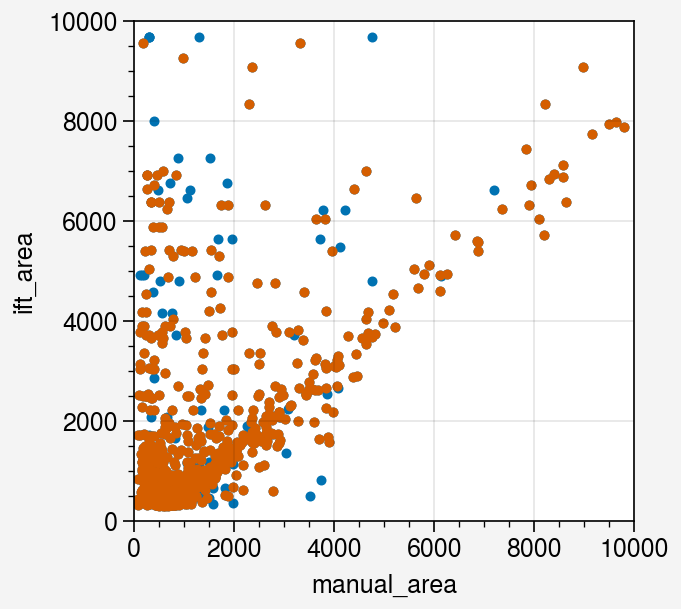

In [86]:
fig, ax = pplt.subplots()
ax.scatter(df_all.manual_area, df_all.ift_area, m='.')
ax.scatter(df_all.loc[df_all.final_classification, 'manual_area'],
           df_all.loc[df_all.final_classification, 'ift_area'], m='.')

ax.format(ylim=(0, 10000), xlim=(0, 10000))

# Selecting "good" overlap
We'll define the "good matches" as ones with high precision and moderately good recall. 
$$\frac{area_{overlap}}{area_{IFT}} > 0.9$$
and 
$$\frac{area_{overlap}}{area_{manual}} > 0.3$$



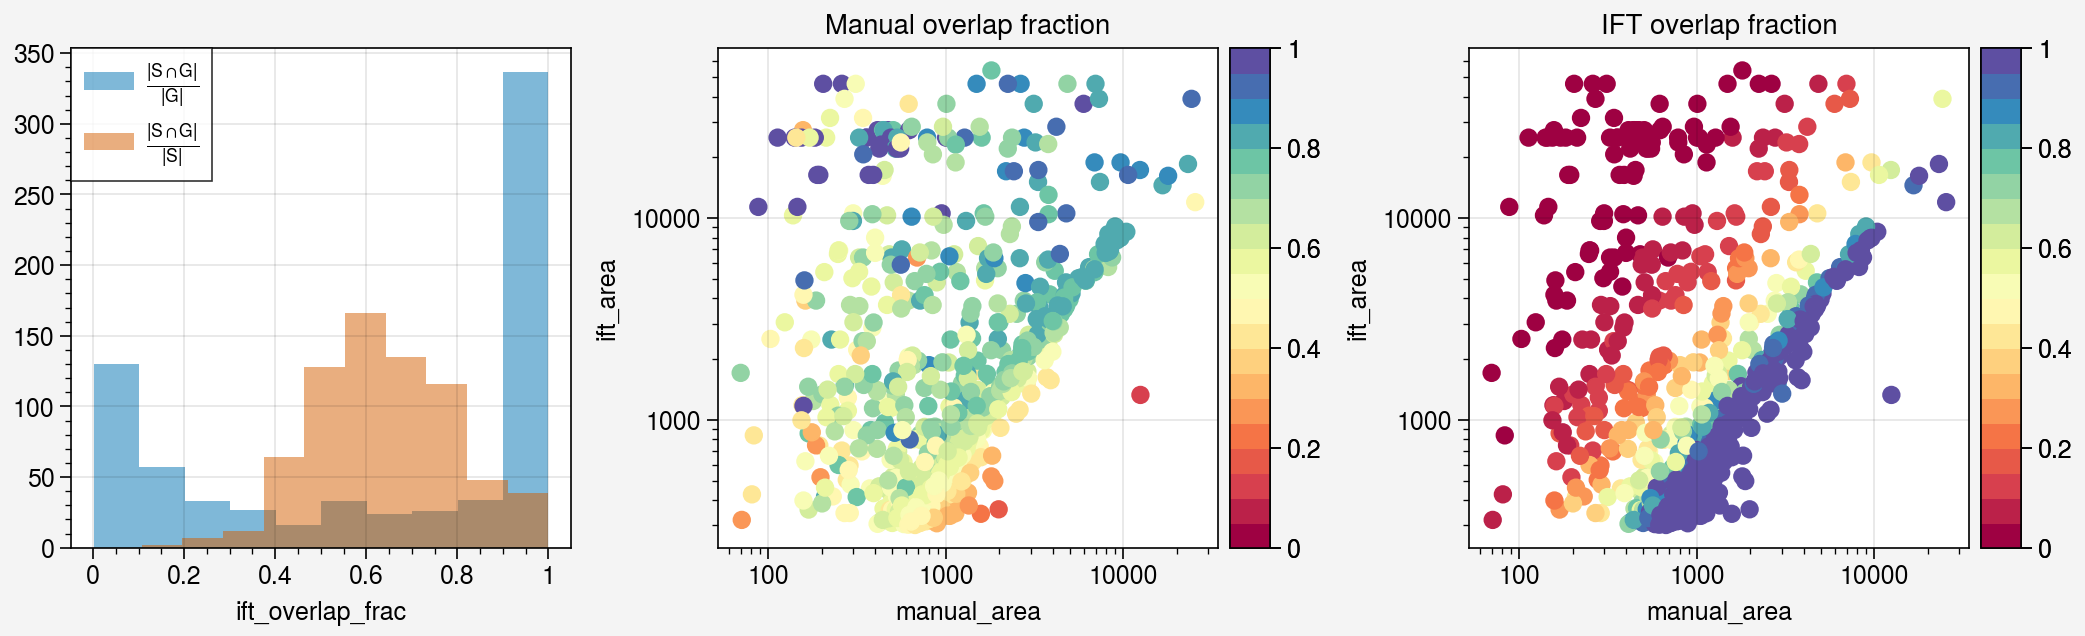

In [87]:
test_idx = df_all.sample(frac=1/3, replace=False, random_state=13245).index
train_idx = df_all.loc[[x for x in df_all.index if x not in test_idx]].index

fig, axs = pplt.subplots(ncols=3, share=False)
df_train = df_all.loc[train_idx]
ax = axs[0]
ax.hist(df_train.loc[:, 'ift_overlap_frac'], label='$\\frac{|S \\cap G|}{|G|}$', alpha=0.5)
ax.hist(df_train.loc[:, 'man_overlap_frac'], label='$\\frac{|S \\cap G|}{|S|}$', alpha=0.5)
ax.legend(ncols=1)

ax = axs[1]
ax.scatter(df_train.manual_area, df_train.ift_area,
           c=df_train.man_overlap_frac,
           cmap='spectral', colorbar='r', N=20, vmin=0, vmax=1)
ax.format(yscale='log', xscale='log', title='Manual overlap fraction')

ax = axs[2]
ax.scatter(df_train.manual_area, df_train.ift_area,
           c=df_train.ift_overlap_frac,
           cmap='spectral', colorbar='r', N=20, vmin=0, vmax=1)
ax.format(yscale='log', xscale='log', title='IFT overlap fraction')

In [91]:
print("Total with matches:", len(df_all.loc[df_all.manual_area.notnull(),:]))
print("Total with no matches:", len(df_all.loc[df_all.manual_area.isnull(),:]))
print("Good match:", len(df_all.loc[(df_all.ift_overlap_frac >= 0.8) & (df_all.man_overlap_frac >= 0.5)]))

Total with matches: 1071
Total with no matches: 1038
Good match: 440


The overlap fractions are akin to the precision and recall. Precision is the fraction of the prediction that is correct, while recall is the fraction of the truth recovered by the prediction. In the figure, we see a wide spread. The blue shows that most of the selected regions have between 80 and 90 percent precision, with a secondary region of very low precision where the manual label and IFT label are not well aligned. The recall is mostly between 40 and 80 percent. 

From the scatter plots, one can see that it is rare but not unheard of for there to be 100% overlap between the manual floe and the IFT floe, but that it frequently occurs that the manual floe is only a tiny portion of the IFT floe. There is a sharp gradient between the near 100% overlap objects and those with very low overlap fractions. 

In general, we find that most of the "Raw" objects have no match, and of those with a match, we find that about 40% are good matches, 10% are oversegmented, and 50% are undersegmented.

In [119]:
df_all['match_type'] = 'Poor'
df_all.loc[df_all.manual_area.isnull(), 'match_type'] = 'No Match'
df_all.loc[(df_all.ift_overlap_frac >= 0.8) & (df_all.man_overlap_frac >= 0.5),
    'match_type'] = 'Good'
df_all.loc[df_all.ift_overlap_frac < 0.8,
    'match_type'] = 'Undersegmented'
df_all.loc[(df_all.man_overlap_frac < 0.5) & (df_all.ift_overlap_frac >= 0.8),
    'match_type'] = 'Oversegmented'
df_all.to_csv('../data/floe_tracker/ift_floe_properties_area_validation.csv')

In [98]:
df_all.groupby('match_type').count()['datetime']

match_type
Good               440
No Match          1038
Oversegmented      108
Undersegmented     523
Name: datetime, dtype: int64

In [99]:
df_all.loc[df_all.final_classification].groupby('match_type').count()['datetime']

match_type
Good              418
No Match          263
Oversegmented      89
Undersegmented    376
Name: datetime, dtype: int64

In [100]:
# What fraction of the "good match" segments are kept in the final tally?
# This calculation isn't quite there yet, because the "False" category includes
# those that have no match, and those who have a match but the quality is low.
df_all[['final_classification', 'match_type']].groupby('match_type').mean()

,final_classification
match_type,
Good,0.95
No Match,0.253372
Oversegmented,0.824074
Undersegmented,0.718929


In [101]:
def filter_image(img, labels):
    """Return image with only objects with label matching one of the labels."""
    new_img = np.zeros(img.shape)
    for lb in labels:
        new_img += (img == lb).astype(int)
    return new_img

In [102]:
import proplot as pplt
for date in man_images:
    fig, ax = pplt.subplots(width=10)
    ax.imshow(np.ma.masked_array(man_images[date], man_images[date]==0), c='b', alpha=0.5)
    ax.imshow(np.ma.masked_array(ift_raw[date], ift_raw[date]==0), c='r', alpha=0.75)
    df_date = df_all.loc[df_all.datetime == date]
    ift_filt = filter_image(ift_raw[date], labels=list(df_date.loc[(df_date.ift_overlap_frac >= 0.9) & (df_date.man_overlap_frac >= 0.4), 'ift_label']))
    ax.imshow(np.ma.masked_array(ift_filt, ift_filt==0), c='gold', alpha=0.9)
    
    ax.format(ylim=(2000, 3000), xlim=(1500, 2500), title=date)
    fig.save('../figures/manual_label_comparison_' + date.strftime('%Y-%m-%d') + '.png', dpi=300)
    pplt.close(fig)

/opt/miniconda3/envs/ift_annals/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/ift_annals/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/ift_annals/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/ift_annals/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/ift_annals/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


# Estimating the radius adjustment factor

We estimate a radius adjustment factor first, then we test a small range of radii using the dilation method.

Total (training) matches 2109
Number of good matches 440
Median (all) nan
Median (good) 7.17


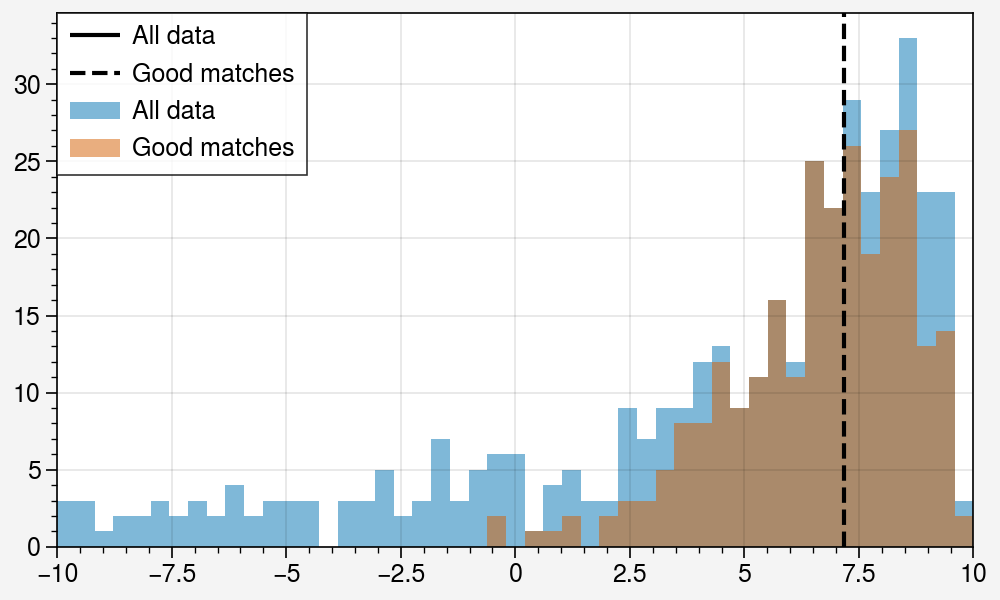

In [104]:
fig, ax = pplt.subplots(width=5, height=3)
area_ift = df_all.loc[train_idx, 'ift_area']
area_man = df_all.loc[train_idx, 'manual_area']
good_match = df_all.match_type == 'Good'
print('Total (training) matches', len(good_match))
print('Number of good matches', np.sum(good_match))
bins = np.linspace(-10, 10, 50)
ax.hist(area_man**0.5 - area_ift**0.5, bins=bins, label='All data', alpha=0.5)
ax.hist(area_man.loc[good_match]**0.5 - area_ift.loc[good_match]**0.5, bins=bins, label='Good matches', alpha=0.5)
med_all = np.median(area_man**0.5 - area_ift**0.5)
med_good_match = np.median(area_man.loc[good_match]**0.5 - area_ift.loc[good_match]**0.5)
ax.format(xlim=(-10, 10))
ax.axvline(med_all, color='k', label='All data', ls='-')
ax.axvline(med_good_match, color='k', label='Good matches', ls='--')
ax.legend(ncols=1)
print('Median (all)', np.round(med_all, 2))
print('Median (good)', np.round(med_good_match, 2))

The estimated best radius with this larger dataset is 7.8. To test the quality after dilation, we'll look at expanding radius with the expansion factor set to 6, 7, 8, 9, and 10, and compute the shape difference and the net area difference for each. Finally, we'll compute the overall error with the test dataset.

Next, we merge into the full dataset again. We'll use the shape difference and the area difference to measure the error and choose the better expansion factor. Ideally, the shape difference and the area difference will point to the same adjustment factor.

In [241]:
# df_all = pd.concat(dataframes, axis=0).reset_index() #.dropna(subset='manual_area')
# df_all['ift_overlap_frac'] = df_all['overlap_area'] / df_all['ift_area']
# df_all['man_overlap_frac'] = df_all['overlap_area'] / df_all['manual_area']
# df_all.drop('level_1', axis=1, inplace=True)
# df_all.rename({'level_0': 'datetime'}, axis=1, inplace=True)

# Identifying the optimal length scale bias adjustment
## Method in the Annals paper: Direct bias adjustment to length scale.
We take the square root of the area, add a length scale offset, then square to get the adjusted area.
$$A^* = (\sqrt{A} + \delta L)^2$$
To optimize this, we are minimizing the error in area
$$\Delta A = A^* - A_T$$
by computing the root mean square error
$$ RMSE = \sqrt{\langle \Delta A_i \rangle_{i \in S}}$$
Here, $A_T$ is the manual floe area and $S$ is the training set.

In [118]:
print('Number of good matches: ', np.sum(df_all.match_type == 'Good'))

good_match = df_all.loc[train_idx].match_type == 'Good'
print('Training:', np.sum(good_match))
good_match = df_all.loc[train_idx].loc[good_match].index

good_match_test = df_all.loc[test_idx].match_type == 'Good'
print('Testing:', np.sum(good_match_test))
good_match_test = df_all.loc[test_idx].loc[good_match_test].index

Number of good matches:  440
Training: 290
Testing: 150


/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_26165/1688839458.py:26: ProplotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead.
  axs.legend(ncols=1)


Final MAE in area (good match):  10.61 km^2
Final MAE in area (all floe pairs, raw):  225.73 km^2
Final MAE in area (all floe pairs, clean):  79.62 km^2
Final Median AE in area (good match):  4.89 km^2
Final Median AE in area (all floe pairs, raw):  18.76 km^2
Final Median AE in area (all floe pairs, clean):  12.0 km^2


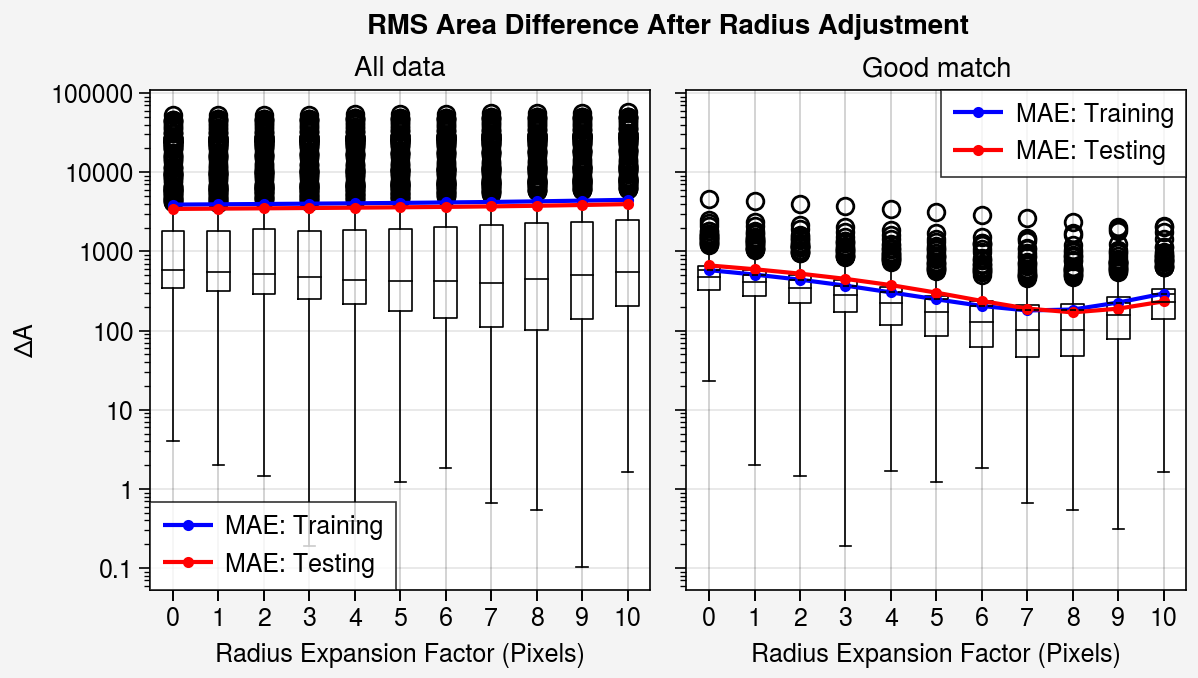

In [115]:
fig, axs = pplt.subplots(ncols=2, sharex=False)

# compute A* for radius 0 to 11
area_adj = pd.DataFrame({str(r): (df_all['ift_area']**0.5 + r)**2 for r in range(0, 11)}).copy()
delta_area = area_adj.copy()

# compute delta A by subtracting the true area
for c in area_adj.columns:
    delta_area[c] -= df_all.loc[:, 'manual_area']

# Plot all candidates on the left, good matches on the right
# Plotting the sqrt of the difference
# "All candidates" is pre-filtering, so lots of false positives in there.
axs[0].boxplot(np.abs(delta_area.loc[train_idx,:]))
axs[0].format(yscale='log', title='All data',  ylabel='$\Delta A$', xlabel='Radius Expansion Factor (Pixels)')

axs[1].boxplot(np.abs(delta_area.loc[good_match,:]), mean=True)
axs[1].format(yscale='log', title='Good match', ylabel='$\Delta A$', xlabel='Radius Expansion Factor (Pixels)')

# Now plot the mean absolute for each radius
axs[0].plot(range(0, 11), [np.mean(np.abs(delta_area.loc[train_idx,r])) for r in delta_area.columns], color='b', marker='.', label='MAE: Training')
axs[0].plot(range(0, 11), [np.mean(np.abs(delta_area.loc[test_idx,r])) for r in delta_area.columns], color='r', marker='.', label='MAE: Testing')

axs[1].plot(range(0, 11), [np.mean(np.abs(delta_area.loc[good_match,r])) for r in delta_area.columns], color='b', marker='.', label='MAE: Training')
axs[1].plot(range(0, 11), [np.mean(np.abs(delta_area.loc[good_match_test,r])) for r in delta_area.columns], color='r', marker='.', label='MAE: Testing')
axs.legend(ncols=1)
axs.format(suptitle='RMS Area Difference After Radius Adjustment')
# Finally, print the RMSE for the test set good matches
df_all_subset = df_all.loc[test_idx,:]
test_idx_and_clean = df_all_subset.loc[df_all_subset.final_classification].index

print('Final MAE in area (good match): ', np.round(np.mean(np.abs(delta_area.loc[good_match_test,'8']))*(0.25**2), 2), 'km^2')
print('Final MAE in area (all floe pairs, raw): ', np.round(np.mean(delta_area.loc[test_idx,'8'])*(0.25**2), 2), 'km^2')
print('Final MAE in area (all floe pairs, clean): ', np.round(np.mean(delta_area.loc[test_idx_and_clean,'8'])*(0.25**2), 2), 'km^2')
print('Final Median AE in area (good match): ', np.round(np.median(np.abs(delta_area.loc[good_match_test,'8']))*(0.25**2), 2), 'km^2')
print('Final Median AE in area (all floe pairs, raw): ', np.round(np.median(delta_area.loc[test_idx,'8'].dropna())*(0.25**2), 2), 'km^2')
print('Final Median AE in area (all floe pairs, clean): ', np.round(np.median(delta_area.loc[test_idx_and_clean,'8'].dropna())*(0.25**2), 2), 'km^2')

# For future work
A potential avenue for future work is to dilate objects rather than using the direct length scale adjustment. Some analysis to that end is below. Keep in mind that the radius expansion factor in the above plot is different than that in the below figures.

In [240]:
%%time
# Recompute area based on the expanded label
for date in dataframes:
    print(date)
    for r in np.arange(0, 11):
        ift_raw_expanded_test = skimage.segmentation.expand_labels(ift_raw[date], distance=r)
        for idx, row in dataframes[date].iterrows():
            sd = np.sum((ift_raw_expanded_test == row.ift_label) != (man_images[date] == row.manual_label))
            dataframes[date].loc[idx, 'shape_difference_' + str(r)] = sd

        new_table = pd.DataFrame(skimage.measure.regionprops_table(ift_raw_expanded_test,
                                                               properties=['label',
                                                                           'area']))

        new_table.rename({'area': 'dilated_area_' + str(r),
                          'label': 'ift_label'}, axis=1, inplace=True)
        if 'dilated_area_' + str(r) in dataframes[date].columns:
            dataframes[date].drop( 'dilated_area_' + str(r), axis=1, inplace=True)
        dataframes[date] = dataframes[date].merge(new_table, left_on='ift_label', right_on='ift_label')

2006-07-10 13:55:15
2009-04-03 13:19:52
2013-04-24 12:39:09
2014-05-01 12:14:19
2018-06-07 11:12:53
CPU times: user 6min 50s, sys: 36.5 s, total: 7min 26s
Wall time: 7min 26s


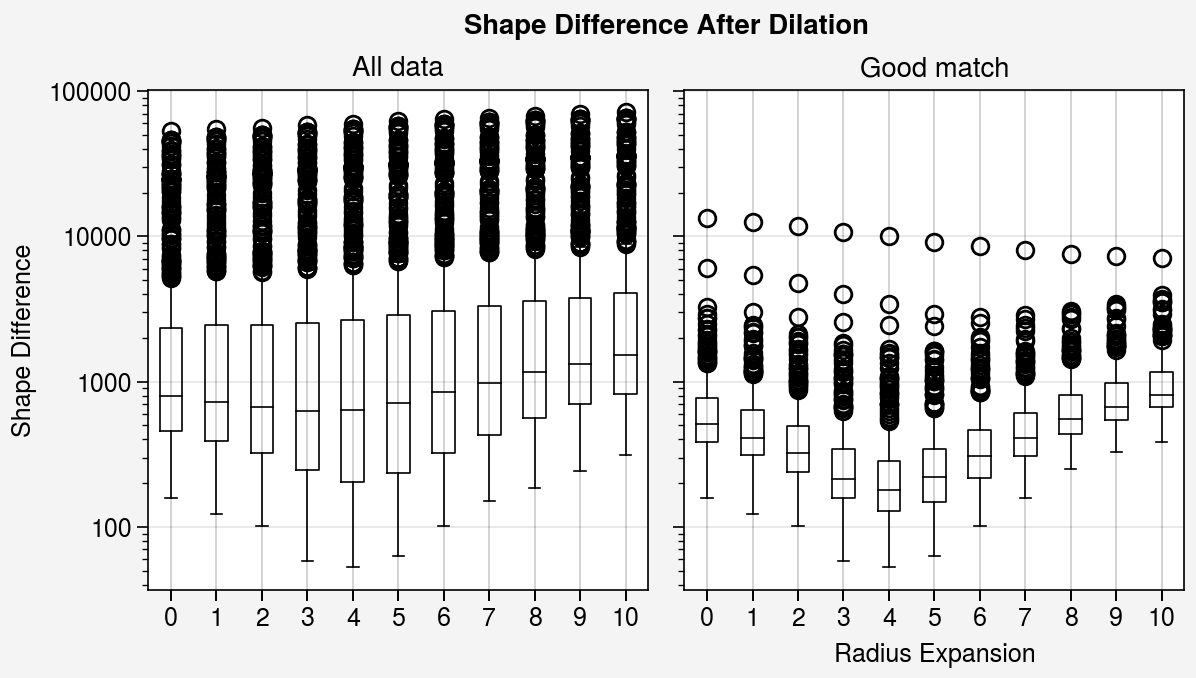

In [245]:
fig, axs = pplt.subplots(ncols=2)
data = df_all.loc[train_idx, ['shape_difference_{r}'.format(r=r) for r in range(0, 11)]]
data.columns = [x.split('_')[-1] for x in data.columns]
axs[0].boxplot(data.loc[train_idx])
axs[0].format(yscale='log', title='All data')

axs[1].boxplot(data.loc[good_match])
axs[1].format(yscale='log', title='Good match', ylabel='Shape Difference', xlabel='Radius Expansion')
axs.format(suptitle='Shape Difference After Dilation')

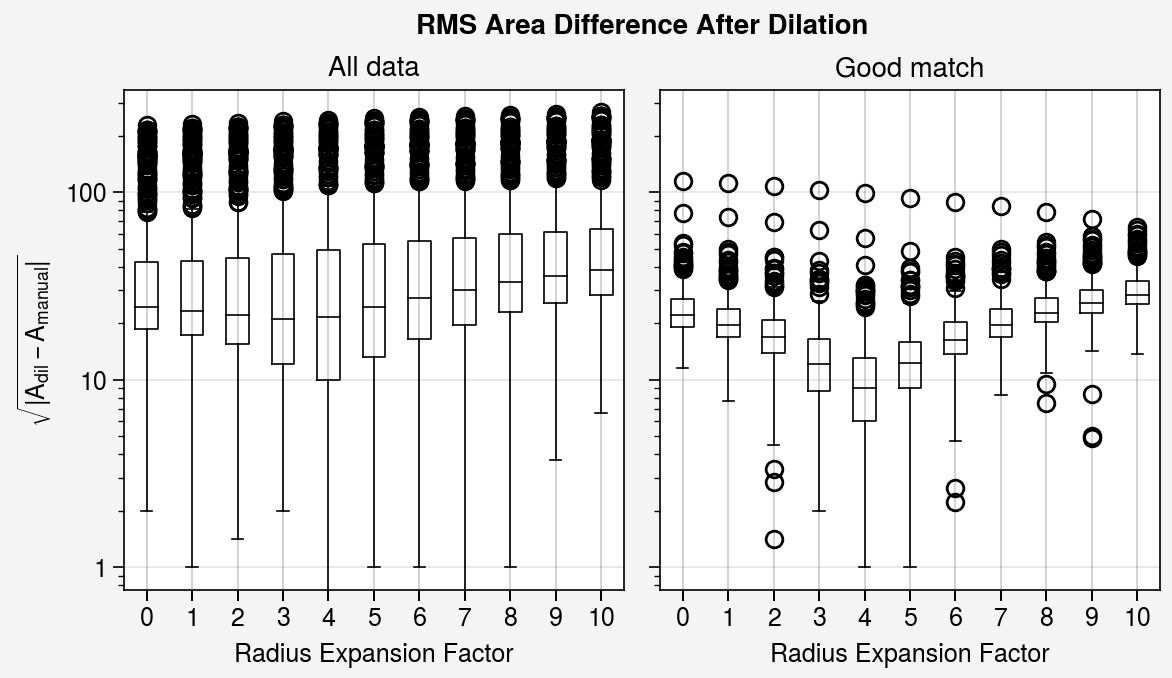

In [246]:
# same kind of figure but for the area difference
fig, axs = pplt.subplots(ncols=2, sharex=False)
data = df_all[['dilated_area_{r}'.format(r=r) for r in range(0, 11)]].copy()
data.columns = [x.split('_')[-1] for x in data.columns]
for c in data.columns:
    data[c] -= df_all.loc[:, 'manual_area']
data = np.abs(data)**0.5

axs[0].boxplot(data.loc[train_idx,:])
axs[0].format(yscale='log', title='All data',  ylabel='$\sqrt{|A_{dil} - A_{manual}|}$', xlabel='Radius Expansion Factor')

axs[1].boxplot(data.loc[good_match,:])
axs[1].format(yscale='log', title='Good match', ylabel='$\sqrt{|A_{dil} - A_{manual}|}$', xlabel='Radius Expansion Factor')
axs.format(suptitle='RMS Area Difference After Dilation')

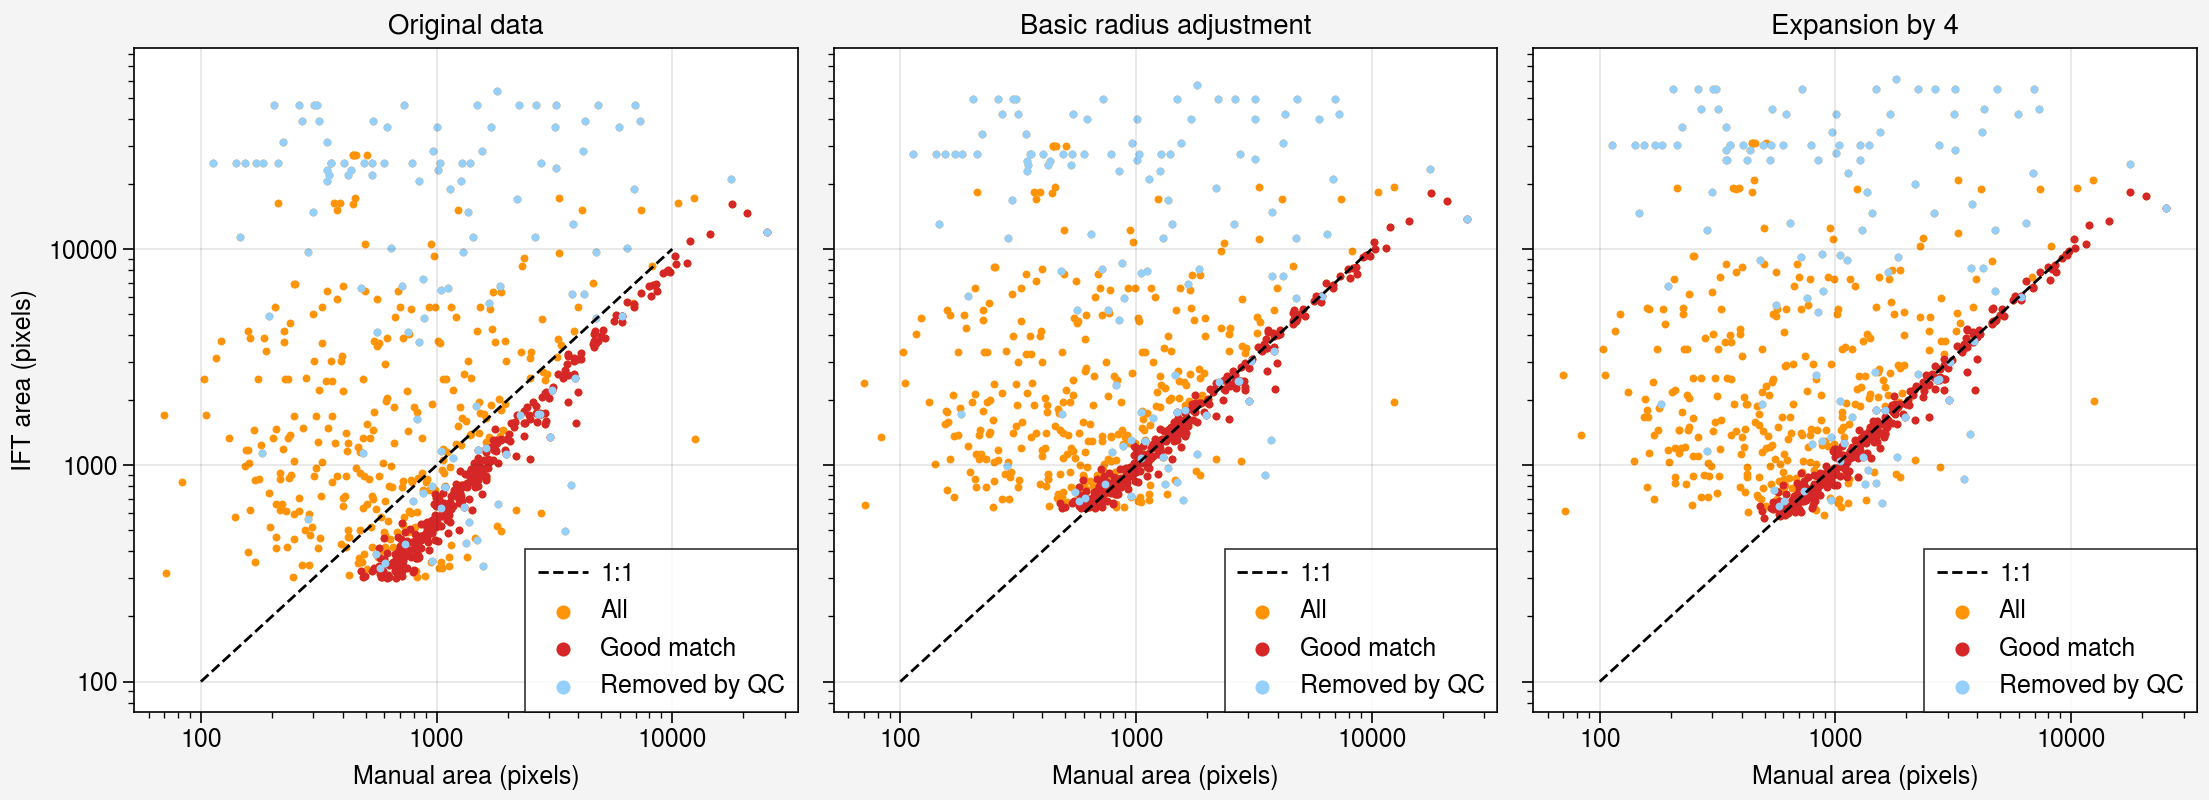

In [433]:
import proplot as pplt

fig, axs = pplt.subplots(height=4, ncols=3, sharex=False)

ax = axs[0]
ax.scatter(df_all.loc[train_idx, 'manual_area'], df_all.loc[train_idx, 'ift_area'], ms=5, label='All', color='tangerine')
ax.scatter(df_all.loc[good_match, 'manual_area'], df_all.loc[good_match, 'ift_area'], ms=5, label='Good match', color='tab:red')
df_removed = df_all.loc[train_idx, :]
df_removed = df_removed.loc[~df_removed.final_classification]
ax.scatter(df_removed.loc[:, 'manual_area'], df_removed.loc[:, 'ift_area'], ms=5,
           label='Removed by QC', color='light blue')
# masking the poor fits
ax.plot([100, 10000], [100, 10000], ls='--', c='k', lw=1, label='1:1')
ax.format(yscale='log', xscale='log', title='Original data',
          ylabel='IFT area (pixels)', xlabel='Manual area (pixels)')
ax.legend(ncols=1, ms=20)

# Adjusting area with prior method (nudge the radius)
ax = axs[1]
r = 7.8
adj_area = (df_all['ift_area']**0.5 + r)**2
ax.scatter(df_all.loc[train_idx, 'manual_area'], adj_area.loc[train_idx], ms=5, label='All', color='tangerine')
ax.scatter(df_all.loc[good_match, 'manual_area'], adj_area.loc[good_match], ms=5, label='Good match', color='tab:red')
idx = df_removed.index
ax.scatter(df_all.loc[idx, 'manual_area'], adj_area.loc[idx], ms=5, label='Removed by QC', color='light blue')

ax.plot([100, 10000], [100, 10000], ls='--', c='k', lw=1, label='1:1')
ax.format(yscale='log', xscale='log', title='Basic radius adjustment', ylabel='IFT area (pixels)', xlabel='Manual area (pixels)')
ax.legend(ncols=1, ms=20)

ax = axs[2]
adj_area = df_all['dilated_area_4']
ax.scatter(df_all.loc[train_idx, 'manual_area'], adj_area.loc[train_idx], ms=5, label='All', color='tangerine')
ax.scatter(df_all.loc[good_match, 'manual_area'], adj_area.loc[good_match], ms=5, label='Good match', color='tab:red')
idx = df_removed.index
ax.scatter(df_all.loc[idx, 'manual_area'], adj_area.loc[idx], ms=5, label='Removed by QC', color='light blue')

ax.plot([100, 10000], [100, 10000], ls='--', c='k', lw=1, label='1:1')
ax.format(yscale='log', xscale='log', title='Expansion by 4', ylabel='IFT area (pixels)', xlabel='Manual area (pixels)')
ax.legend(ncols=1, ms=20)

The best-performing radius adjustment produces approximately as good of a match as the dilation method, so for now it is not worth re-doing the analysis.